# Clustering

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import cdist
import umap.umap_ as umap

## Goal

In this file, we will create a visualization of the companies in our dataset following a clustering procedure.

In [2]:
df = pd.read_csv('Final_company_aspect_matrix_with_counts.csv')

## Preparing necessary columns

In [3]:
# Create sentiment weighted score to cluster companies
df["sentiment_weighted"] = df["avg_star_rating"] * df["n_mentions"]

# total reviews each firm received (across all aspects)
firm_totals = df.groupby("firm")["n_mentions"].sum()

# proportion of all mentions that are for this aspect
df["share"] = df["n_mentions"] / df["firm"].map(firm_totals)

# combine with sentiment to normalize:
df["sentiment_share"] = df["avg_star_rating"] * df["share"]

# Build the full matrix of aspect scoring ("sentiment share") per firm
matrix  = df.pivot_table(index="firm", columns="aspect", values="sentiment_share").fillna(0)

In [4]:
df.head()

,firm,aspect,avg_star_rating,n_mentions,sentiment_weighted,share,sentiment_share
0,AFH Wealth Management,culture,2.500000,2,5.0,0.095238,0.238095
1,AFH Wealth Management,hr & recruitment,3.000000,4,12.0,0.190476,0.571429
2,AFH Wealth Management,management,3.200000,5,16.0,0.238095,0.761905
3,AFH Wealth Management,pay,2.666667,3,8.0,0.142857,0.380952
4,AFH Wealth Management,people,4.000000,1,4.0,0.047619,0.190476


In [5]:
matrix.head()

aspect,culture,diversity & inclusion,growth & learning,hr & recruitment,job role clarity,job security,management,office & location,pay,people,performance feedback,perks & benefits,remote work,stress & pressure,teamwork & collaboration,tools & resources,work-life balance
firm,,,,,,,,,,,,,,,,,
AFH Wealth Management,0.238095,0.000000,0.000000,0.571429,0.000000,0.000000,0.761905,0.000000,0.380952,0.190476,0.000000,0.190476,0.000000,0.000000,0.476190,0.238095,0.190476
AJ Bell,0.302326,0.000000,0.465116,0.337209,0.093023,0.023256,0.151163,0.383721,0.279070,0.360465,0.000000,0.325581,0.000000,0.000000,0.348837,0.139535,0.093023
ASOS,0.173780,0.006098,0.253049,0.237805,0.048780,0.003049,0.164634,0.201220,0.143293,0.307927,0.030488,0.551829,0.000000,0.121951,0.219512,0.094512,0.253049
AXA UK,0.391304,0.115942,0.144928,0.391304,0.057971,0.028986,0.304348,0.173913,0.347826,0.159420,0.086957,0.434783,0.057971,0.000000,0.144928,0.231884,0.144928
Abcam,0.682927,0.000000,0.463415,0.024390,0.121951,0.000000,0.280488,0.304878,0.085366,0.304878,0.000000,0.158537,0.000000,0.292683,0.231707,0.134146,0.317073


In [6]:
print(matrix.shape)

(315, 17)


## Performing K-Means and Silhouette Score to find optimal number of clusters

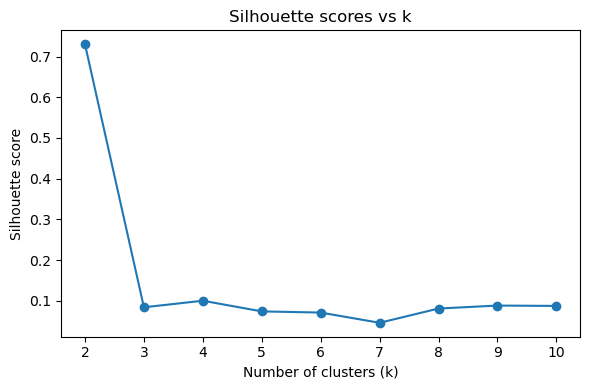

In [7]:
# Scale the matrix
scaler = StandardScaler()
X = scaler.fit_transform(matrix)

# Search over a range of k and record silhouette
silhouette_scores = {}
for k in range(2, 11):        
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores[k] = silhouette_score(X, labels)

# Convert to a DataFrame
sil_df = (pd.DataFrame(list(silhouette_scores.items()), columns=["k", "silhouette"]).sort_values("k").reset_index(drop=True))

# Visualise
plt.figure(figsize=(6, 4))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores vs k")
plt.tight_layout()
plt.show()

# Optional – fit the *best* model and attach labels to the original matrix
# best_k = sil_df.loc[sil_df["silhouette"].idxmax(), "k"]
# best_kmeans = KMeans(n_clusters=int(best_k), n_init=10, random_state=42)
# matrix["cluster"] = best_kmeans.fit_predict(X)

# Save or inspect `matrix` if you want:
# matrix.to_csv("/mnt/data/company_clusters.csv")

In [8]:
sil_df.head()

,k,silhouette
0,2,0.730055
1,3,0.084218
2,4,0.100317
3,5,0.074149
4,6,0.071239


### Inspecting this result: why is only 2 clusters the optimal number?

In [9]:
kmeans2 = KMeans(n_clusters=2, n_init=30, random_state=0).fit(X)
labels, counts = np.unique(kmeans2.labels_, return_counts=True)
print(dict(zip(labels, counts)))

outlier_idx = np.where(kmeans2.labels_ == 1)[0][0]
outlier_firm = matrix.index[outlier_idx]
print("Outlier firm:", outlier_firm)

# Quick look at its profile
display(matrix.loc[outlier_firm].sort_values(ascending=False).head())

{0: 314, 1: 1}
Outlier firm: Ryan LLC


aspect
tools & resources           2.5
job role clarity            2.5
culture                     0.0
people                      0.0
teamwork & collaboration    0.0
Name: Ryan LLC, dtype: float64

<span style="color: red;"> Outlier detected! Ryan LLC has only two aspects detected with star rating equal to 5 and number of mentions equal to 1.</span>

### Solution: filter dataframe for n_mentions >= threshold

In [10]:
MIN_MENTIONS = 10 #Threshold

firm_totals = df.groupby("firm")["n_mentions"].transform("sum")
mask = firm_totals >= MIN_MENTIONS
df_filtered = df[mask].copy()

print(f"Dropped {len(df) - len(df_filtered)} firms "
      f"(< {MIN_MENTIONS} mentions); {df_filtered['firm'].nunique()} remain.")

Dropped 156 firms (< 10 mentions); 282 remain.


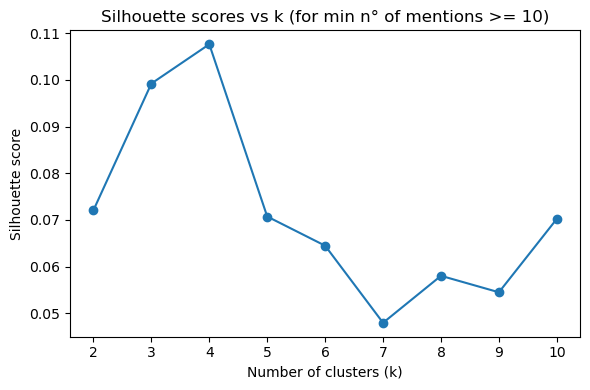

Silhouette scores: {2: 0.07208323483004156, 3: 0.09922839968676188, 4: 0.10764601530042395, 5: 0.0707354381900213, 6: 0.0644813286268853, 7: 0.047965380209072005, 8: 0.0580331914029775, 9: 0.054503553649876635, 10: 0.07023539496750258}
Best k = 4


In [14]:
# K-MEANS on filtered df
firm_totals_filtered = df_filtered.groupby("firm")["n_mentions"].transform("sum")
df_filtered["share"] = df_filtered["n_mentions"] / firm_totals_filtered
df_filtered["sentiment_share"] = (
        df_filtered["avg_star_rating"] * df_filtered["share"])

M_share = (df_filtered.pivot_table(index="firm", columns="aspect",values="sentiment_share").fillna(0))

# Silhouette loop
X = StandardScaler().fit_transform(M_share)
silhouette_scores = {}
for k in range(2, 11):        
    kmeans = KMeans(n_clusters=k, n_init=30, random_state=0)
    labels = kmeans.fit_predict(X)
    silhouette_scores[k] = silhouette_score(X, labels)

# Convert to a DataFrame
sil_df = (pd.DataFrame(list(silhouette_scores.items()), columns=["k", "silhouette"]).sort_values("k").reset_index(drop=True))

# Visualise
plt.figure(figsize=(6, 4))
plt.plot(sil_df["k"], sil_df["silhouette"], marker="o")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette score")
plt.title("Silhouette scores vs k (for min n° of mentions >= 10)")
plt.tight_layout()
plt.show()
print("Silhouette scores:", silhouette_scores)
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("Best k =", best_k)

## Clustering strategy 1: VARIANCE

In [16]:
STRATEGY = "variance"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['people', 'growth & learning', 'work-life balance']


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


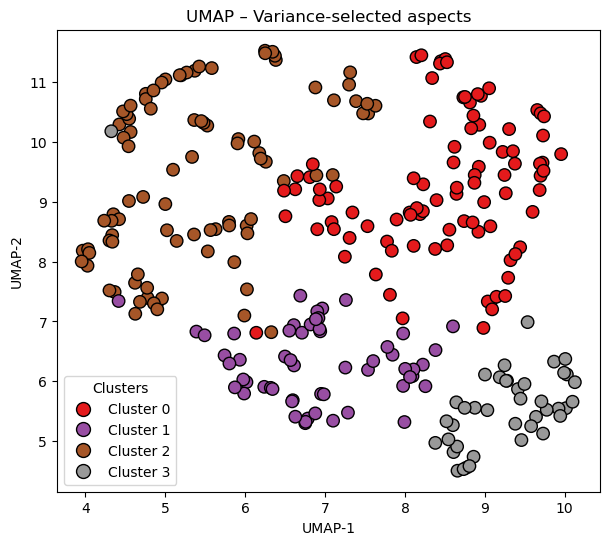

In [17]:
# Plot variance clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

### Inspecting VARIANCE clusters

In [ ]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect   people  growth & learning  work-life balance
cluster                                              
0          0.27               0.32               0.45
1          0.54               0.34               0.26
2          0.22               0.23               0.22
3          0.32               0.61               0.17


- Winners:
    - Best "people" --> cluster 1
    - Best "growth & learning" --> cluster 3
    - Best "work-life balance" --> cluster 0
- Loser:
    - Cluster 2

In [19]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0    93
1    56
2    92
3    41
Name: count, dtype: int64 

🟢 Cluster 0 • 93 firms
Abcam, Accor, Amey, Angard Staffing, Aon, Arnold Clark, AstraZeneca, B and M Retail, BBC, BDO …

🟢 Cluster 1 • 56 firms
AlixPartners, Anglian Water, Apple, BNP Paribas, Babylon Health, Bain and Company, Balfour Beatty, Boston Consulting Group, British Airways, CBRE …

🟢 Cluster 2 • 92 firms
AFH Wealth Management, ASOS, AXA UK, Active Care Group, Adecco, Age UK The National Charity, Arcadia, Aviva, B and Q, BHS …

🟢 Cluster 3 • 41 firms
AJ Bell, Accenture, American Express, BAT, Barts Health NHS Trust, Bayer, Bullhorn, Career Legal, Citi, Citizens Advice …



/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_24326/1473241163.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


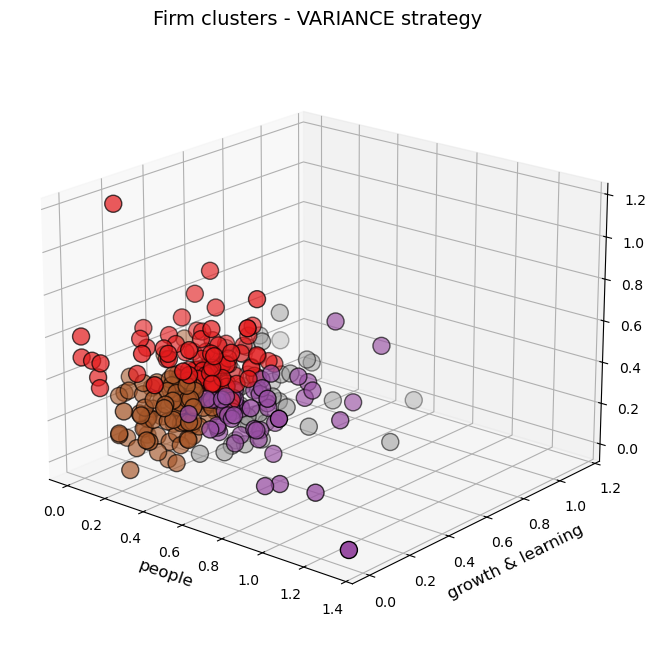

In [ ]:
# 3‑D scatter of firms on (people, growth&learning, work-life balance)

# 1) Grab the three columns in the right order
axes = ["people", "growth & learning", "work-life balance"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k")

ax.set_xlabel("people", fontsize=12)
ax.set_ylabel("growth & learning", fontsize=12)
ax.set_zlabel("work-life balance", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters - VARIANCE strategy", fontsize=14)
plt.show()

## Clustering strategy 2: MANUAL

In [26]:
STRATEGY = "manual"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['pay', 'work-life balance', 'culture']


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


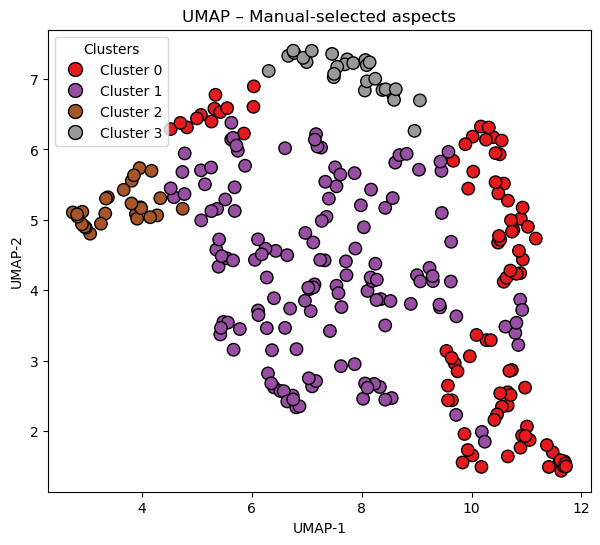

In [27]:
# Plot MANUAL clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

### Inspecting MANUAL clusters

In [29]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect    pay  work-life balance  culture
cluster                                  
0        0.45               0.30     0.22
1        0.23               0.36     0.29
2        0.21               0.18     0.60
3        0.15               0.06     0.18


- Winners:
    - Best "pay" --> cluster 0
    - Best "work-life balance" --> cluster 1
    - Best "culture" --> cluster 2
- Loser:
    - Cluster 3

In [30]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0     88
1    141
2     26
3     27
Name: count, dtype: int64 

🟢 Cluster 0 • 88 firms
AFH Wealth Management, AJ Bell, AXA UK, Active Care Group, Adecco, AstraZeneca, Aviva, B and Q, BAT, BT …

🟢 Cluster 1 • 141 firms
ASOS, Accenture, Accor, Age UK The National Charity, American Express, Amey, Angard Staffing, Anglian Water, Aon, Apple …

🟢 Cluster 2 • 26 firms
Abcam, AlixPartners, Bayer, Brewin Dolphin, Bullhorn, Capital Group, CarShop UK, CityFibre, Communities and Local Government, Dynatrace …

🟢 Cluster 3 • 27 firms
BPP Holdings, Babylon Health, Barchester Healthcare, Barratt Developments, Barts Health NHS Trust, Career Legal, Christie s, Citizens Advice, Colosseum Dental, Creative Support …



/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_24326/1180057479.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


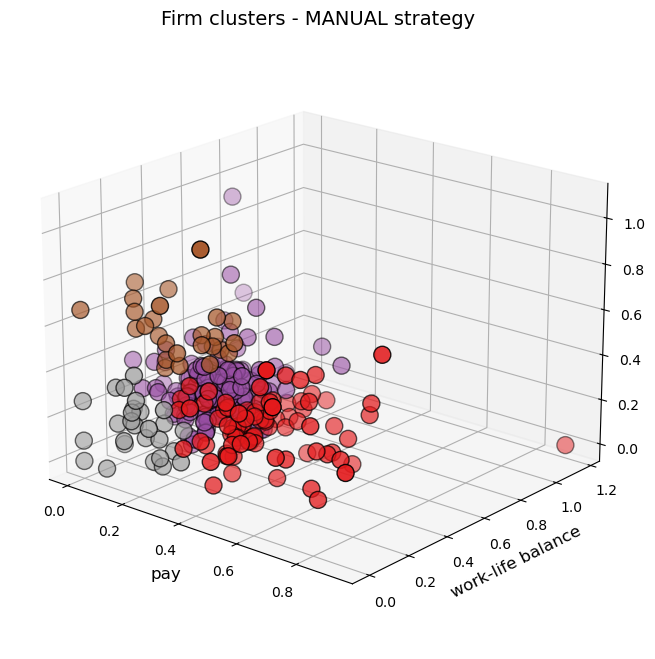

In [31]:
# 3‑D scatter of firms on (pay, work-life balance, culture)

# 1) Grab the three columns in the right order
axes = ["pay", "work-life balance", "culture"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k")

ax.set_xlabel("pay", fontsize=12)
ax.set_ylabel("work-life balance", fontsize=12)
ax.set_zlabel("culture", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters - MANUAL strategy", fontsize=14)
plt.show()

## Clustering strategy 3: MENTIONS

In [32]:
STRATEGY = "mentions"      
N_KEEP   = 3               # how many aspects to keep

# Pick columns based on strategy
if STRATEGY == "variance":
    variances = M_share.var().sort_values(ascending=False)
    cols = variances.head(N_KEEP).index

elif STRATEGY == "mentions":
    total_mentions = (
        df_filtered.groupby("aspect")["n_mentions"].sum()
        .sort_values(ascending=False)
    )
    cols = total_mentions.head(N_KEEP).index

elif STRATEGY == "manual":
    cols = ["pay", "work-life balance","culture"]
else:
    raise ValueError("STRATEGY must be variance, mentions, or manual")

print(f"Keeping {len(cols)} aspects:\n", list(cols))

X_sel = M_share[cols]

Keeping 3 aspects:
 ['pay', 'work-life balance', 'growth & learning']


/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


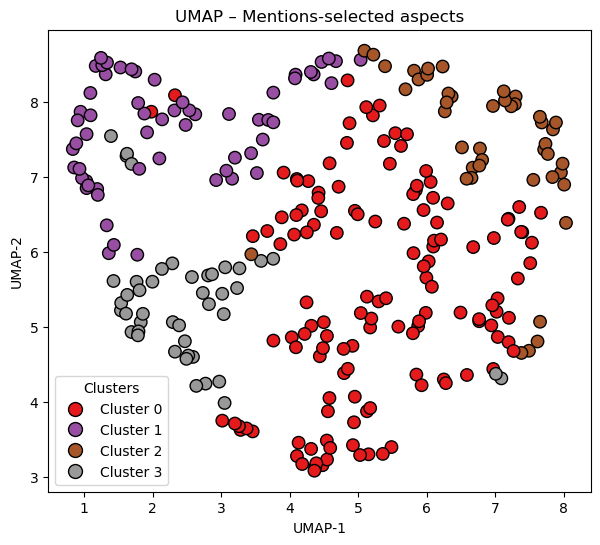

In [33]:
# Plot mentions clusters 
X_scaled = StandardScaler().fit_transform(X_sel)
clust = AgglomerativeClustering(n_clusters=4, linkage="ward").fit(X_scaled) #adjust number of clusters
labels = clust.labels_
emb = umap.UMAP(random_state=42).fit_transform(X_scaled)

plt.figure(figsize=(7,6))
scatter = plt.scatter(emb[:,0], emb[:,1],
                      c=labels, cmap="Set1",
                      edgecolor="k", s=80)

unique = sorted(set(labels))
handles = [ plt.Line2D([], [], marker='o', linestyle='',
                       markerfacecolor=scatter.cmap(scatter.norm(lab)),
                       markeredgecolor='k', markersize=10,
                       label=f"Cluster {lab}")
            for lab in unique ]
plt.legend(handles=handles, title="Clusters", frameon=True)

plt.title(f"UMAP – {STRATEGY.capitalize()}‑selected aspects")
plt.xlabel("UMAP‑1"); plt.ylabel("UMAP‑2")
plt.show()

### Inspecting MENTIONS Clusters

In [34]:
# Average value of each aspect per cluster
clusters = X_sel.copy()
clusters["cluster"] = labels      
profile = (
    clusters.groupby("cluster")
            .mean()               
            .round(2)
            .sort_index()
)
print(profile)

aspect    pay  work-life balance  growth & learning
cluster                                            
0        0.27               0.23               0.26
1        0.21               0.44               0.42
2        0.50               0.42               0.20
3        0.22               0.18               0.58


- Winners:
    - Best "pay" --> cluster 2
    - Best "work-life balance" --> cluster 1
    - Best "growth & learning" --> cluster 3
- Loser:
    - Cluster 0

In [35]:
sizes = clusters["cluster"].value_counts().sort_index()
print("\nCluster sizes:\n", sizes, "\n")

for cl in sorted(clusters["cluster"].unique()):
    print(f"🟢 Cluster {cl} • {sizes.loc[cl]} firms")
    print(", ".join(clusters.query("cluster == @cl").index[:10]), "…\n")


Cluster sizes:
 cluster
0    134
1     60
2     44
3     44
Name: count, dtype: int64 

🟢 Cluster 0 • 134 firms
AFH Wealth Management, ASOS, AXA UK, Active Care Group, Age UK The National Charity, Anglian Water, Apple, Arcadia, AstraZeneca, Aviva …

🟢 Cluster 1 • 60 firms
Accor, American Express, Amey, Aon, Arnold Clark, B and M Retail, BBC, BNY Mellon, BP, Bain and Company …

🟢 Cluster 2 • 44 firms
Adecco, Angard Staffing, Barnett Waddingham, Blue Arrow, Brook Street, Co op, Covea Insurance, Cromwell Tools, DFS Furniture, DHL Supply Chain …

🟢 Cluster 3 • 44 firms
AJ Bell, Abcam, Accenture, AlixPartners, BAT, Barts Health NHS Trust, Bayer, Bullhorn, Capital Group, Citi …



/var/folders/b0/3lm1b6yx0z52q8tv2nvq6qc40000gn/T/ipykernel_24326/3337722419.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  customcmap = cm.get_cmap("Set1", len(labels_unique))


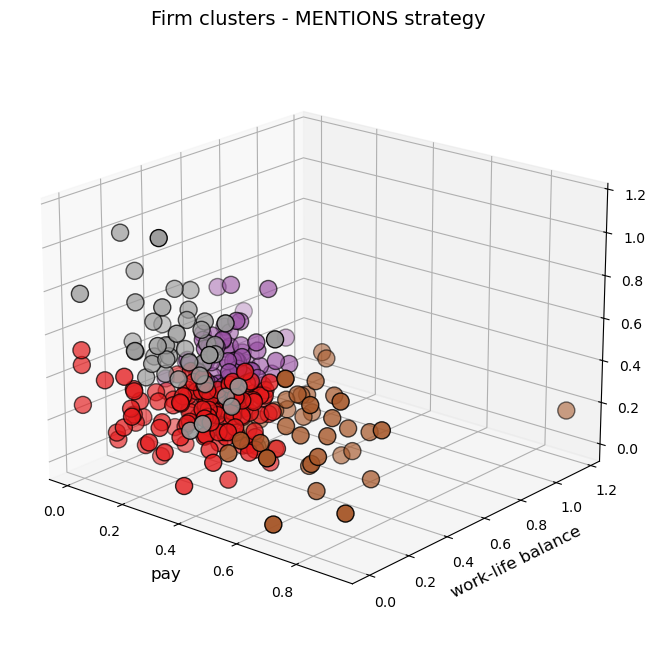

In [36]:
# 3‑D scatter of firms on (pay, work-life balance, growth & learning)

# 1) Grab the three columns in the right order
axes = ["pay", "work-life balance", "growth & learning"]
xyz  = X_sel[axes].values                  

# 2) Make sure labels start at 0 for colormap indexing
labels_unique = np.unique(labels)
label_map     = {old: i for i, old in enumerate(labels_unique)}
color_labels  = np.vectorize(label_map.get)(labels)

customcmap = cm.get_cmap("Set1", len(labels_unique))

# 3) Plot
fig = plt.figure(figsize=(12, 8))
ax  = fig.add_subplot(111, projection="3d")

ax.scatter(
    xyz[:, 0], xyz[:, 1], xyz[:, 2],
    c=color_labels.astype(float),
    cmap=customcmap,
    s=150, edgecolor="k")

ax.set_xlabel("pay", fontsize=12)
ax.set_ylabel("work-life balance", fontsize=12)
ax.set_zlabel("growth & learning", fontsize=12, labelpad=10)
ax.view_init(20, -50)
ax.set_title("Firm clusters - MENTIONS strategy", fontsize=14)
plt.show()